# Synthetic experiment
This notebook reproduces the *synthetic experiments* described in Section 5 of the paper titled "On the convergence of ADAM and beyond" (Reddi, Kale and Kumar 2018).

## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Optimizer

In [2]:
class Adam:

    def __init__(self, amsgrad=False, beta1=0.9, beta2=0.99):
        self.amsgrad = amsgrad
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = 0
        self.v = 0

    def update(self, x, grad, lr):
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        v = self.beta2 * self.v + (1 - self.beta2) * grad**2

        if not self.amsgrad:
            self.v = v
        else:
            self.v = max(self.v, v)

        update = lr * self.m / math.sqrt(self.v)
        return np.clip(x - update, -1, 1)


## Experiment

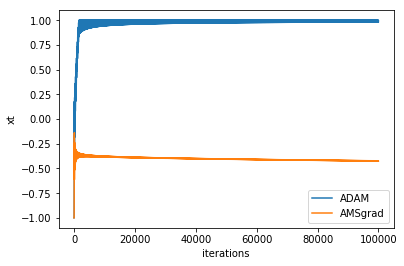

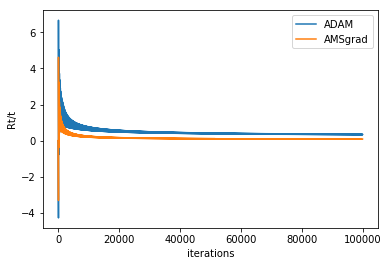

In [3]:
T = 100000
stochastic = False

iterations = np.arange(1, T + 1, 1)
adam = Adam()
amsg = Adam(amsgrad=True)

xs_adam, xs_amsg = [], []
regrets_adam, regrets_amsg = [], []

x_adam, x_amsg = 0, 0
loss_adam, loss_amsg, loss_opti = 0, 0, 0

for t in iterations:
    lr_t = 1 / math.sqrt(t)

    if stochastic:
        grad = (1010 if np.random.randint(0, 1000) == 0 else -10)
    else:
        grad = (1010 if t % 101 == 1 else -10)

    x_adam = adam.update(x_adam, grad, lr_t)
    x_amsg = amsg.update(x_amsg, grad, lr_t)

    xs_adam.append(x_adam)
    xs_amsg.append(x_amsg)

    loss_adam += grad * x_adam
    loss_amsg += grad * x_amsg
    loss_opti += grad * -1

    regrets_adam.append((loss_adam - loss_opti) / t)
    regrets_amsg.append((loss_amsg - loss_opti) / t)

plt.xlabel('iterations')
plt.ylabel('xt')
plt.plot(iterations, xs_adam, label='ADAM')
plt.plot(iterations, xs_amsg, label='AMSgrad')
plt.legend()
plt.show()

plt.xlabel('iterations')
plt.ylabel('Rt/t')
plt.plot(iterations, regrets_adam, label='ADAM')
plt.plot(iterations, regrets_amsg, label='AMSgrad')
plt.legend()
plt.show()
